In [1]:
### PREAMBLE
# Nonlinear modeling, overfitting, and regularization
# nonlinear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

This set of notes really deals with two different topics: nonlinear modeling and the issue of generalization.  These are really two separate and distinct issues in machine learning, but they arise very naturally in contection with each other, and so we choose to introduce there at the same time here.  Nonetheless, it is important to also understand that they are different topics, and that generalization issues can arise for any type of classifier (linear or nonlinear), and than nonlinear hypothesis functions are of independent interest.  With this caveat in mind, though, let's see how they can arise together.

## Nonlinear modeling

To introduce the issue of nonlinear modeling, let's return our original example of predicting peak electrical demand from high temperature.  Let's load the data we used last time (though this time we won't load from the raw files but just load the data frame we created last time from a CSV file, to see how to load from the raw data, see the ML intro notes).

In [2]:
import pandas as pd
df = pd.read_csv("temp_demand.csv", index_col="Date")

Last time we considered the high temperature and peak demand in the summer months, obtained as follows.

In [21]:
df_summer = df[list(map(lambda x : str(x)[4:6] in ["06", "07", "08"], df.index))].copy()
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

As we discussed, the relationship between high temperature and electrical demand is well-modelled by a linear function during the summer months, when (at least in Pittsburgh), electricity in summer is dominated by air conditions (so with higher temperatures comes higher consumption).  However, this is clearly not the case of the entire year.  Indeed, if our previous linear model is to be believed then with lower temperatures we would continue to have lower and lower consumption (until, at some point, we'd start generating electricity).  Naturally, this is not the case, and if we instead consider the _entire_ year of temperature and peak dmeand, then another picture emerges.

In [30]:
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.xlim([0,95])

(0, 95)

This captures the effects we expect.  Although peak demand increases sharply with consumption after a high temperature of 70 degrees or so (precisely the range where air conditioning usually starts), below this the demand actually start to increase with _lower_ temperature -- though not with as steep a slope, due to the fact, for example, that most heating in Pittsburgh is done with gas rather than with electricity, and other loads that do increase with lower temperatures tend to be smaller in magnitude that air conditions.

If we were to fit a linear model to this data, it would look like the following.

(0, 95)

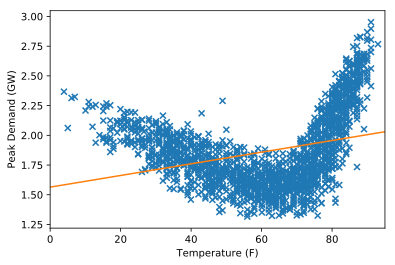

In [6]:
X = np.array([df["Temp"].values, np.ones(len(df))]).T
y = df["Load"].values
theta = np.linalg.solve(X.T @ X, X.T @ y)
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.plot([0,100], [theta[1], 100*theta[0]+theta[1]], 'C1')
plt.xlim([0,95])

In a very precise sense this _is_ the best fit to the data: it is the line that minimizes the sum of squared errors between the data points and the points on this line (remember, this is the definition of linear regression).  However, of course in another sense this is a very poor fit, as it misses the defining characteristic of the data, namely that peak demand has this characteristic of first gently decreasing with higher temperature up to about 70 degrees, then increasing rapidly.

To capture data of this type, we clearly want some way of expressing nonlinear relationships in the data.  Fortunately, this is possible without actually leaving the domain of so-called "linear regresion".  The trick we are going to use is a simple one: rather than have features $x^{(i)}$ which only include the "raw" inputs such as temperatuare (plus other raw inputs such as weekday indicators that we saw previously), we are going to make build features that include _nonlinear_ functions of the underlying inputs.  For example, we could choose the following features
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{HighTemperature}^{(i)})^2 \\
\mathrm{HighTemperature}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
which also include a quadratic function of the high temperature variable.  If we choose this representation, then our linear hypothesis function $h_\theta(x) = \theta^Tx$ is now given by
\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{HighTemperature}^{(i)})^2 + \theta_2 \mathrm{HighTemperature}^{(i)} + \theta_3
\end{equation}
which is a _quadratic_ function of the high temperature.  Importantly, however, the hypothesis function is still a linear function of the parameters, and so the exact same solution methods work as before (including the exact solution), just by passing a different feature matrix.

Let's see how this works in practice.  In this setting we're actually going to normalize features to the range $[-1,+1]$ even with the exactly least-squares solution for numerical reasons.  High polynomials get very large very quickly, and if we aren't careful it's easy to overload the range of double precision floating point values.

In [59]:
x = df["Temp"].values
min_x, max_x = x.min(), x.max()
x = 2*(x - min_x)/(max_x - min_x) - 1

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)

theta = ls_poly(x, y, 2)
print(theta)

[ 1.19886894 -0.19235301  1.5888731 ]


Now that we've computed the solution, let's plot is as before.  Since our hypothesis is no longer a line we can't plot it by simply specifying two points, but the rough procedure works the same as before.

In [60]:
def plot_regression_poly(theta):
    degree = len(theta)-1
    xt0 = np.linspace(0,95, 400)
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(degree,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(df["Temp"], df["Load"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([0,95])
    plt.ylim(ylim)
    
plot_regression_poly(theta)

This looks better, but quadratic function is symmetric around its minimum point, and the data we're trying to fit is definitely not symmetric. Thus, we may want a cubic function.

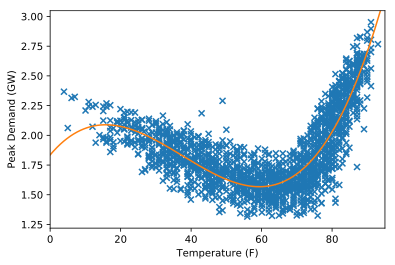

In [53]:
plot_regression_poly(ls_poly(x,y,3))

This looks better except for the low end, so maybe one more degree.

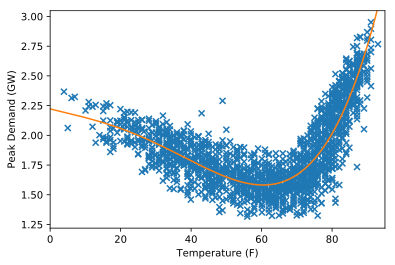

In [54]:
plot_regression_poly(ls_poly(x,y,4))

This is starting to look like a pretty good fit to the data.  But so far high degree has been better, so let's keep going, trying a degree 10 polynomial.

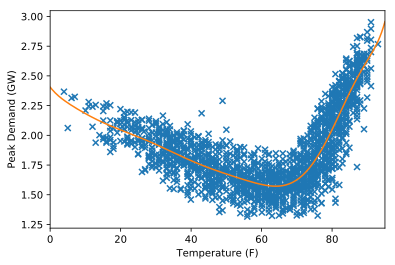

In [55]:
plot_regression_poly(ls_poly(x,y,10))

Still not bad.  Let's keep going.

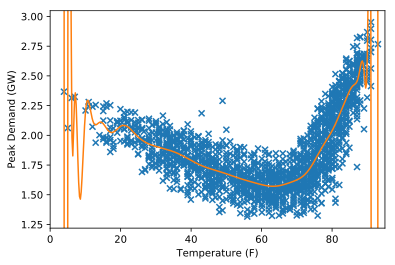

In [61]:
plot_regression_poly(ls_poly(x,y,100))

Something very bad has happened at this point.  Especially at the tail ends of the data, where the data points are spaced less closely, we start to get very odd patterns for the data.  But the important point is that this is actually a very good fit to the data from a least-squares perspective.  As you can see from the figure, the lines pass _exactly_ through many of the data point (most obvious on the left hand side of the plot), whereas for the "better" fits we had above, our function didn't pass exactly through those points, so actually suffered more loss.  But there is an obvious way in which the degree 100 polynomial fit, despite having _lower_ loss, is actually a worse approximation to the underlying data.  This brings us to the second topic of these notes, which is the issue of generlization and overfitting.

## Generalization and overfitting

Recall from our previous discussions that the canoncial machine learning problem that we solve with every algorithm is the following
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}
i.e., to minimize the sum of losses on the data set.  However, in a more fundamental way, this is not really our goal.  We ultimately do not care about achieving low loss specifically on the points that we are feeding into the algorithm: we already _know_ the true output for each of these data points, and if we want to "predict" these points precisely, we could just look up each point in a database (assuming we have some way of referring to the points uniquely).  What we _really_ want from a machine learning algorithm is the ability to predict will on _new_ data points _of the same type_ as those we learned our model on.  We don't care about knowing was the peak demand _was_ on previous days we have already seen; we care about being able to predict what the peak demand will _be_ tomorrow given the high temperature as input.

**Generalization error** This discussion leads us to the notion of _generalization error_.  Informally, the generalization error is just the error (or more generally, the loss) we would experience not on the training data itself, but on new data drawn from the "same distirbution" as the training data.  _This_ is really the quantity we want to minimize, not the error on the training data itself.  Because when we run our machine learning algorithm on new data, all that will matter is its generalization performance.

What the above example illustrated was an instance of _overfitting_, the situation where the training error is low, but the generalization error is high.  This occurs because we are explicitly trying to minimize the loss on the training set, and if the expressiveness of of hypothesis function is small enough, then we can make this loss arbitrarily small, usually by fitting to pecularities in the training data that provide no real benefit when looking at new data.

**Overfitting in least squares** As a simple example, let's consider the the case of least squares regression, when we choose the number of features $n$ to be the same as the number of examples $m$ (for example, we could achieve this by choosing a very high degree polynomial); let's also assume that that the underlying data is distinction for each data point, which will imply (we won't worry about proving this formally, you can just take it as a fact) that that features for each example a linearly independent.  Then we can look at our least squares solution
\begin{equation}
\begin{split}
\theta & = (X^T X)^{-1} X^T y   \\
& = X^{-1} X^{-T} X^T y \\
& = X^{-1} y
\end{split}
\end{equation}
(where the assumption about linear independence implies that $X$ is invertible, and we use the property that $(AB)^{-1} = B^{-1} A^{-1}$ when $A$ and $B$ are invertible) and we therefore have $X\theta = y$, i.e., the predictions on the training set are perfect.  However, unless the model was exactly capture by $m$ points, there would be no reason to expect tha the resulting fit would generalize well to new points. 

**Overfitting and model complexity**

In general, we expect something like the following behavior when it comes to overfitting.  We're showing the "cartoon" form here but we will shortly see what this looks like in practice.

![Cartoon illustration of overfitting](overfitting.svg)

When model complexity is low, both training and generalization loss are high (here model complexity can mean any type of representational power of the model, but since we have covered this so far, you can think of it just as the degree of the polynomial in our feature vector).  As we increase model complexity, the both training and generalization performance start to decrease with training loss usually slightly lower that generalization loss (due to the simple fact tha we explicitly optimized training loss).  As we futher increase model complexity, training loss will continue to only decrease: by adding additional representational power to our model, we will only fit the data better and better, since we are explicitly choosing parameters to minimize this loss.  But at a certain point, generalization loss will start to increase again.  Our goal when choosing the "right" model for a particular machine learning problem is to find the model with lowest generalization error, the minimum in the red line above.  However, we cannot do so using the training set alone, because performance on the training set (the blue line), gives us no clue at to the performance of the generalization loss.

### Cross validation

The fundamental idea we're going to use here is simple enough that you have likely already thought of how to do this, even if you haven't seen the process before.  Although we cannot easily have access to the _true_ generalization loss (this is an expectation over the true underlying distribution of data, as we will define shortly).  However, we can easily obtain a reasonable approximation to it by a procedure called cross validation.

![Simple 70-30 cross validation split](cv_split.svg)

The idea of cross validation is simple.  Given the entirety of our training data, we take some fixed percentage, say 70% of the data, and call this our "new" training set.  We then take the remaining data (30% in this case), and call it the _holdout_ or _validation_ set.  The basic idea is that we will use the emprical error or loss on this holdout set as an approximation for the generalization error.  This works because, unlike the training set, we do _not_ choose the parameters of the model based upon the validation set.  This means that there is no way for the parameters to overfit to this data, and thus the validation set still provides a reasonable estimate of generalization error even _after_ the parameters have been trained.

**Note:** it is important that I explicitly have not used the work _test set_ above.  While training/testing set splits in many data science problems are created in a similar manner, there is something fundamentally different about a test set than a validation set, which we will discuss more when we talk about evaluating machine learning algorithms.

Let's see how to generate these training and validation sets.

In [45]:
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df["Temp"].iloc[idx_train].values, df["Load"].iloc[idx_train].values
x_cv, y_cv = df["Temp"].iloc[idx_cv].values, df["Load"].iloc[idx_cv].values

In [46]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")

Now let's generate features for the training and cross validation sets.  The standard procedure here is that we should compute all feature normalization based upon the training set alone, and only afterwards apply this same normalization to the test set.  Note that in some cases it is permissable to include cross validation data points (obviously not the labels) into the normalization process (namely if you expect to have similar access to all the "unlabled" data you will be evaluating the system on prior to training the system), but it's much more standard to simply use just the new training set for everything, including normalization.

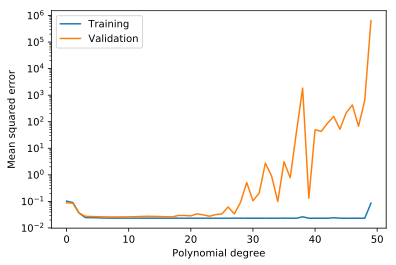

In [48]:
min_x, max_x = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x)/(max_x - min_x) - 1
x_cv = 2*(x_cv - min_x)/(max_x - min_x) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    

err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Don't worry about the little increases in training loss at the high end of the figure: these result from numerical instabilities that occur as you have polynomials that that high a degree (simply put, at this range the numerical accuracy of double precision is not high enough).  But the point here is hopefully clear, that as model complexity rises, training error decreses (modulo numerical stability), while cross validation error can increase greatly (notice we are using a log scale for the plot).  But it's also worth emphasizing that this is not a monotonic process: again due to peculiarities in the data, the cross validation loss can jump around significantly.  You want to pay more attention to the general tread instead of any particular value of the loss.

So which model is the "best" fit to the data.  This is a somewhat subjective question, since it likely involves some combination of a model with low cross-validation error _and_ some subjective notion about preferring "simpler" models all else being equal.  Let's look more closely at the range of low loss.

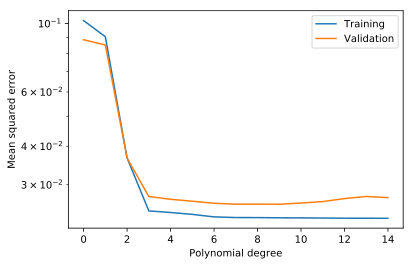

In [49]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Looking at the plot, maybe a polynomial degree somewhere between six and eight looks like it has the lowest cross validation error.  Though it would also be reasonable, I think, to advocate for a polynomial of degree three, as the loss sharpely decreases up until this point, and then only improves to a minor degree afterwards, so we may want to prefer the simplicity of the degree three polynomial.

** Terminology: parameters and hyperparameters ** It is worth introducing a bit of notation here.  As we have done before, we refer to the parameters of the hypothesis function itself (i.e., $\theta$), just in this manner, as the _parameters_ of model.  Any additional elements, though, such as the degree of the polynomial (which is _not_ of the native parameter of the hypothesis function, as the hypothesis function assumes a given number of features), are referred to as _hyperpameters_.  The basic idea of cross-validation is that we use the training set to choose our parameters, while we use the cross-validation set to choose our hyperparameters.  We'll see more instances of hyperparameters shortly.

### K-fold cross validation

Another variant of cross-validation is common enough that it bears mentioning.  One potential issue with cross-validation is that we are "at the mercy" of a single random split of our data.  If one "outlier" data point appears in the training versus validation set, this could have a substantial influence on the reported accuracy of the method and the resulting choice of hyperparameters.  As as example, in the above setting we actually (intentionally, for the purposes of demonstration), picked a setting where one of the extreme points (the observation with lowest temperature) appeared in the validation set rather than the training set; because high-degree polynomial regression in particularly bad at extrapolating to data points outside the range of what was seen during training, this one point contributes substantially to the high cross validation error we see for high polynomial degrees.  But I would argue that this is actually realistic: we do expect there to be some points that lie outside the range of what we have seen before, and a reasonable ML method should have some ability to extrapolate at least to some small degree.  But had we split the data differently, we wouldn't see this behavior so dramatically (try out a few different random seed above to see this yourself).

This motivates a setting where _every_ point in the data is used at least once for validation.  We can accomplish this via _k-fold cross validation_.  The basic idea here is that instead of breaking the data set into a single training and validation set, we divide the dataset into $k$ approximately equal-sized segments, or folds.

![Illustration of dataset division for k-fold cross validation](kfold.svg)

After doing this, we then train and evaluate the model $k$ different times, using each fold as a validation set, and all the remaining folds as the training set, and then finally average the results together over all the folds.  This intuitively can provide a "better" estimate of the generalization error, because we are using every point in our data set as a validation point at least one time.  The trade off is that we now need to train $k$ times as many models (one for each collection of $k-1$ folds); for settings where we can run the algorithm very quickly, this is not too steep a cost, but when the algorithms are costly to run and when data is plentiful, it is more common to simply use traditional cross validation.

### Additional variants of cross validation

There are a few additional variants of cross validation that are common enough that you should be familiar with them.

**Leave-one-out cross validation ** This is the "natural" extreme of k-fold cross validation, the case where we choose $k=m$, i.e., a separate fold for each data point.  In this setting, we train on all put one of the examples, test on that one example, and repeat this $m$ times.  While this is typically very costly to compute (because it involves now solving $m$ different training problems), it somewhat surprisingly turns out that for least squares there are some linear algebra tricks we can play that make computing this quantity no worse (in terms of big-O notation) than comptuting a _single_ least squares solution.  This may seem quite surprising, and is another nice property of least squares.  But leave-one-out cross validation is also not perfect.  When running k-fold cross validation there is a tendency to think of each fold as a "separate trial" and thus the combination of $k$ of these trials could give us a very good estimate of the true generalization error.  But this is actually not correct: because the training process is highly correlated over the folds (they share the majority of the same data), they are not actually independent runs of the training/validation process, and so the accuracy of our generalization error estimate does not necessarily increase with the number of folds (in fact, it's hard to show from a theoretical perspective that there is much advantage to doing so at all).  Proving all this requires a more rigorous treatment of generalization and cross validation procedures, which we won't address here, but be aware of these issues insofar as they highlight that k-fold cross validation is not an ideal procedure for estimating the true generalization loss.

Finally, there are other reasons to avoid k-fold cross validation in some settings.  For instance, if we are considering a time series forecating problem, it always makes sense to build a validation set that occurs _after_ the training set, so that we aren't effectively predicting the past using the future.  And yes, we did actually make this mistake in our above example, where the data is temporal yet we used a random split of the data.  The underlying assumption we made is that the temperature/load relationship over the five years does _not_ depend on time, but in a more rigorous study we would probably want to validate this assumption further before using random splits for training/validation (or to be safe, just perform validation on the last year, and training on the first five, or something similar).

**Stratified cross-validation ** This type of cross-validation tries to keep some property (most commonly the proportion of positively and negatively labeled examples, but other options are possible too) consistent between the training and validation sets.  If, for instance, you have data that is highly unbalanced, with many more negative than positive labels, you may want to use stratified cross validation to ensure that you get a similar number of each type in the training and validation sets, to ensure that your results aren't unduly influenced by a "bad" random seed (for example, which might put very few or even no positive examples in the validation set, making the validation loss not very meaningful).

## Regularization

We have so far seen that the degree of the polynomial we use for our nonlinear features acts as a nice characterization of the model complexity.  But there is another notion of model complexity that is also important to understand, the _magnitude_ of the model parameters.  To see why this is important, let's look again at our degree 100 polynomial fit to the data.

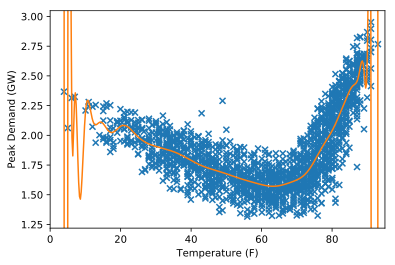

In [61]:
plot_regression_poly(ls_poly(x,y,100))

Let's also look at the actual weights involvd with this fit.

In [62]:
theta = ls_poly(x,y,100)
print(theta[:4])

[-225430.02270515  764586.40932062 -713994.9434542  -871745.10747298]


The way that we get the polynomial to _exactly_ pass through the points requires extremely high values for the coefficients: we need to set the coefficients just so that the different polynomial terms largely "cancel" out precisely at the data points and fit the function exactly to the data.

This also suggests another method for controlling the complexity of the model class: restircting the magnitude of the coefficients.  This is the basis of the technique known as _regularization_.

Formally, regularization is often written as an additional term in the canonical machine learning problem.  Instead of simply minimizing the average loss, we minimize the average loss plus a term that penalizes the magnitude of the coefficients (usually some function of a norm of the weights, often just the sum of squared weights also called $\ell_2$ regularization, but other functions are possible as well).  For example, let's consider the following optimizaiton problem:
\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right) + \lambda \sum_{i=1}^n \theta_i^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_.  $\lambda$ effectively trades off between minimizing the training loss (which naturally "wants" to use large weights), and keeping the weights small.  If $\lambda = 0$, we ignore the regularization term entirely, and just minimize training loss; but as $\lambda \rightarrow \infty$, the _only_ relevant term in the optimization problem becomes the sum of the squared weights, which is clearly minimized if we just pick $\theta = 0$.  Thus, by varying $\lambda$ between zero and some very large constant, we can "sweep out" different ranges of model complexity.


### Regularization in least squares

Before visualizing what our regularized solutions actually look like, let's look at how to solve the regularized problem, at least in the least squares setting.  It will turn out for squared loss and a penalty on the squared weights, there is an exact solution to the regularized least-squares problem, just as there was with traditional least squares.

To see this, let's consider the objective with $\ell_2$ regularization and squared loss.
\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \left (\theta^T x^{(i)} - y^{(i)} \right) + \lambda \sum_{j=1}^n \theta_j^2
\end{equation}

Recall from our previous lecture that the gradientn with respect to $\theta$ of the squared loss term was just 
Taking the gradient of the objective with respect to $\theta$ we get
\begin{equation}
\nabla_\theta \frac{1}{m}\sum_{i=1}^m \left (\theta^T x^{(i)} - y^{(i)} \right) = $\frac{2}{m}X^T(X\theta - y)$
\end{equation}
so we just need to compute the gradient of the regularization term
\begin{equation}
\nabla_\theta \lambda \sum_{i=j}^n \theta_j^2.
\end{equation}
This particular term is actually very simple.  Since the partial derivative of the regularization term is just given by
\begin{equation}
\frac{\partial}{\partial \theta_k} \lambda \sum_{i=1}^n \theta_i^2 = 2 \lambda \theta_k
\end{equation}
we have the the whole gradient term in simply given by 
\begin{equation}
\nabla_\theta \lambda \sum_{i=j}^n \theta_j^2 = 2 \lambda \theta.
\end{equation}

Finding the least-squares solution therefore just involves finding the solution to the matrix equation
\begin{equation}
\begin{split}
& \frac{2}{m}X^T(X\theta^\star - y) + 2 \lambda \theta^\star = 0 \\
\Longrightarrow \;\; & (X^T X + m \lambda I) \theta^\star = X^T y \\
\Longrightarrow \;\; & \theta^\star = (X^T X + m \lambda I )^{-1} X^T y.
\end{split}
\end{equation}

Because the $m$ term there looks a bit cumbersome, it's common to simply wrap the constant $m$ into the regularization term itself, and write the regularized solution as 
\begin{equation}
\theta^\star = (X^T X + \lambda I)^{-1} X^T y
\end{equation}
which is the form we'll use to compute the regularized least squares solution below.

Note that the above discussion also provided us with a way of incorporating regularization into gradient descent procedures to: the gradient of the $\ell_2$ regularization term, for instance is just $2 \lambda \theta$, so in gradient descent we simply add this additional term to our gradients, and run the algorithm as we did before.  In fact, we already did this when we run our previous gradient descent algorithms for classification (the SVM explicitly has this regularization term included), and the formulation hopefully makes more sense after this discussion if it did not previously.

### Visualizing regularization



Let's see what this looks like on our 100 degree polynomial.  The figure above shows the situation with no regularization, i.e, $\lambda = 0$.  If we instead choose $\lambda = 1$, we get the following figure.

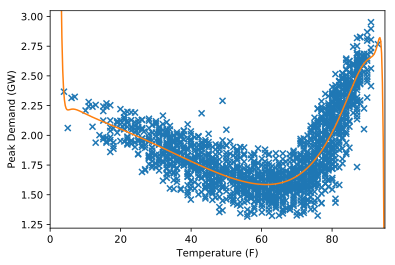

In [66]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

theta = ls_poly_reg(x, y, 1.0, 100)
plot_regression_poly(theta)

What happens outside the range of the data is still often poorly specified, but this looks substantially better what what we had before.  And we can indeed see that the magnitude of the parameters $\theta$ are much smaller.

In [67]:
print(theta[:5])

[ 0.00567776 -0.02367691  0.00552413 -0.02264579  0.00538301]


(to be continued)